# Notebook 1: exploration et nettoyage

In [731]:
# Core libraries
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Imputer for missing data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [732]:
train = pd.read_csv("dataset/application_train.csv")
test = pd.read_csv("dataset/application_test.csv")

In [733]:
# Garder que les variables qui ont au moins 60% des données renseignées
def drop_cols_nans(data):

    frac = len(data) * 0.6
    data = data.dropna(thresh=frac, axis=1)
    return data

def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Quantité de contrats': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Quantité de contrats",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Pourcentage avec une valeur TARGET de 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution de %s" % feature)
    sns.distplot(train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   

# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = train.loc[train['TARGET'] != 0]
    t0 = train.loc[train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Plot de densité', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

## Le jeu de données

Dans le jeu de données fourni par Home Credit, nous avons 8 fichiers de données en format csv. L'aggregation de tous les fichiers augmente la quantité de données et complique les variables en permettant qu'une légère amélioration à la performance de notre modèle.  

C'est pour cette raison que dans le cadre de cet analyse, qui doit rester interprétable, nous allons nous servir seulement de application_train.csv et application_test.csv.  

`application_{train|test}.csv`  
* Il s'agit de notre jeu de données principale, séparé en deux fichiers : Train (avec TARGET) et Test (sans TARGET)
* Chaque ligne represente un crédit  

`bureau.csv`
* Ce jeu de données contient les informations concernant les crédits précédents avec des autres emprunteurs que Home Credit.
* Chaque ligne corréspond à un crédit, le SK_ID_CURR, ou l'ID de chaque emprunteur, nous permet de réunir les informations concernant les anciens prêts.  

`bureau_balance.csv`
* Solde mensuel de chaque crédit précédent avec Home Credit.

`POS_CASH_balance.csv`
* Soldes mensuels des prêts POS (point of sales) et cash que le demander a eux avec Home Credit.

`credit_card_balance.csv`
* Soldes mensuels des cartes de crédit précédentes du demandeur avec Home Credit.

`previous_application.csv`
* Toute ancienne demande de crédit avec Home Credit.

`installments_payments.csv`
* Historique des remboursements pour les précédents crédits avec Home Credit.
* Une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.  

In [734]:
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [735]:
print("Le jeu de données training contient {} lignes et {} features.".format(train.shape[0], train.shape[1]))

Le jeu de données training contient 307511 lignes et 122 features.


In [736]:
test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [737]:
print("Le jeu de données test contient {} lignes et {} features.".format(test.shape[0], test.shape[1]))

Le jeu de données test contient 48744 lignes et 121 features.


### Analyse des features

In [738]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Nous avons 65 features numériques continues, 41 features numériques discrètes et 16 features categorielles.

In [739]:
df_cat = train.select_dtypes(include='object')
df_int = train.select_dtypes(include='int64')
df_float = train.select_dtypes(include='float64')

### La variable cible : TARGET

In [740]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

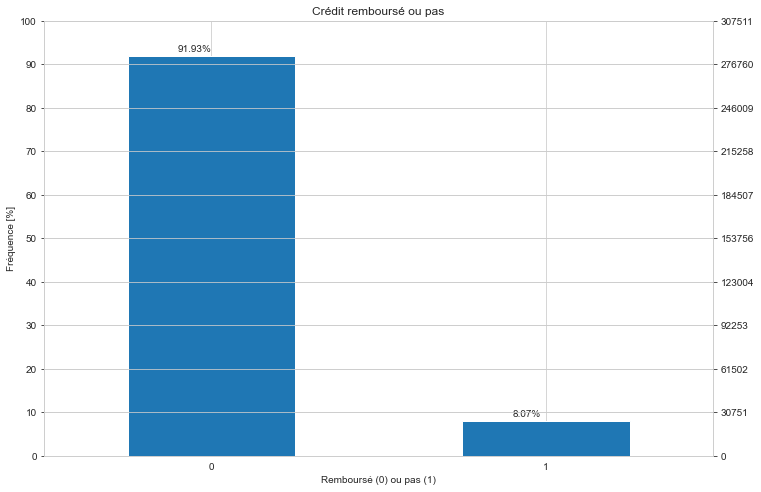

In [741]:
plt.figure(figsize=(12,8))
plt.title('Crédit remboursé ou pas')
plt.xlabel('Remboursé (0) ou pas (1)')
plt.ylabel('Fréquence [%]')

ax = (train.TARGET.value_counts()/len(train)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(train)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

<b>Observations :</b>  

* Nous pouvons constater avec la distribution de la variable TARGET que nous avons un jeu de données avec des classes desequilibrés (data imbalance). 
* 91.93% des emprunteurs remboursent leur crédit, ceci est notre classe majoritaire et est representé par "0"
* 8.07% des eprunteurs ne remboursent pas leur crédit, ceci est notre classe minoritaire et est representé par "1"
* Puisque notre jeu de données est desequilibré, il faudra appliquer une algorithme afin de l'equilibrer ainsi que choisir la bonne métrique, car la précision (accuracy) ne sera pas adaptée dans notre cas. ROC-AUC, Recall, la matrice de confusion ou Fbeta-score peuvent nous être utiles.

<b> Features categorielles </b>

In [742]:
df_cat.describe(include="all")

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


Le portrait de l'emprunteur moyen : 
* Les femmes souscrivent plus de prêts que les hommes.
* Les prêts cash sont les plus fréquents.
* Les prêts sont souscrit plus par les personnes qui ne possèdent pas de voiture mais possèdent de l'immobilier.
* La plupart des clients ne sont pas accompagnés au rendez-vous.
* Les ouvriers sont la profession la plus fréquente chez les clients.

#### Type de contrat
La minorité des contrats sont de type revolving loans, par contre il s'agit d'un grand nombre de crédits non-remboursés.

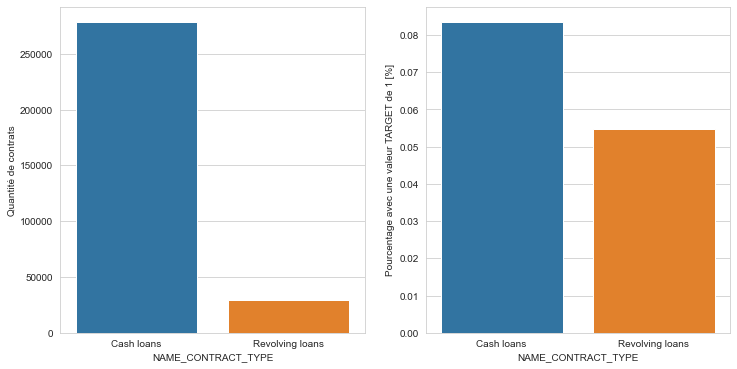

In [743]:
plot_stats('NAME_CONTRACT_TYPE')

#### Sexe du client
Il y a presque le double de femmes que des hommes, et les hommes ont une tendance légèrement plus forte à ne pas rembourser le crédit.

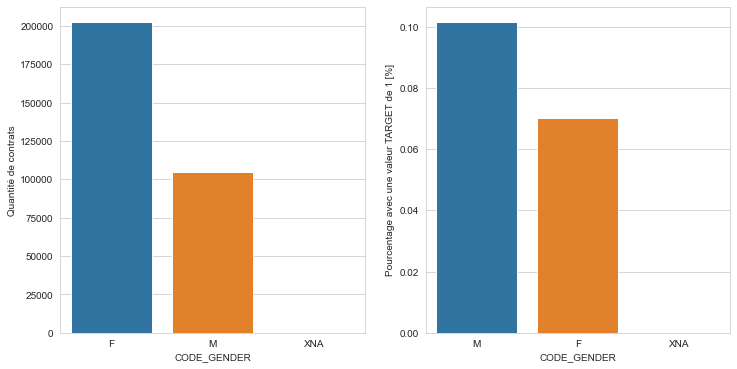

In [744]:
plot_stats('CODE_GENDER')

#### Type de contrat
Presque deux fois plus de clients ne possèdent pas de voiture, et les clients qui possèdent une voiture ont plus de chances à rembourser le crédit.
En ce qui concerne l'immobilier, presque deux fois plus de clients possèdent de l'immobilier par rapport aux clients qui n'en possèdent pas.

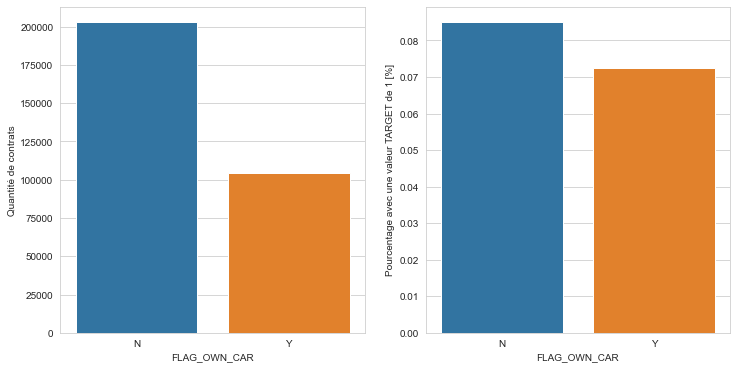

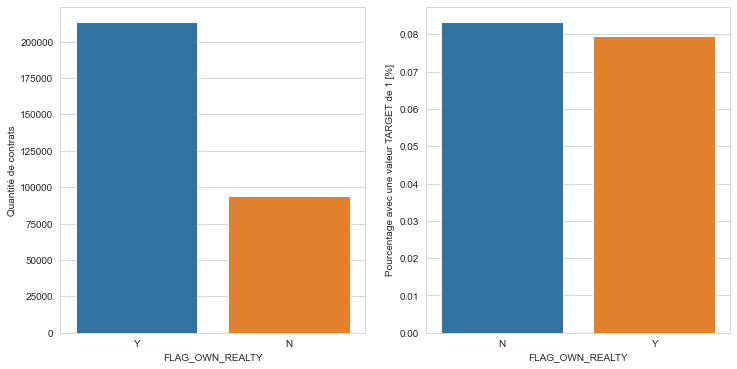

In [745]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

#### Situation familiale
En général, on voit que plus grand la famille, plus difficile c'est de rembourser un crédit.

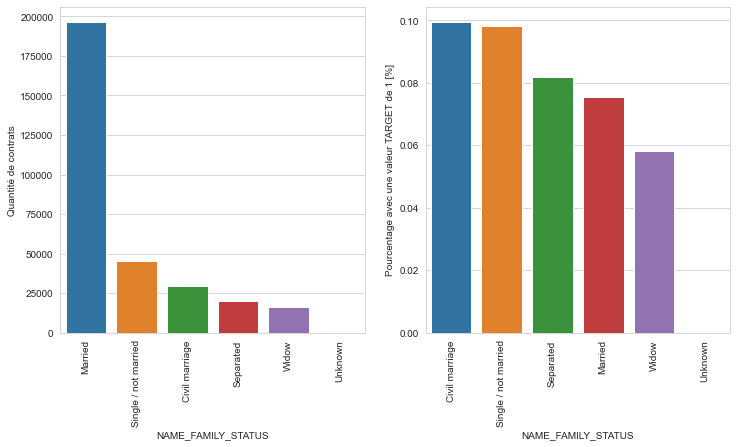

In [746]:
plot_stats('NAME_FAMILY_STATUS',True, True)

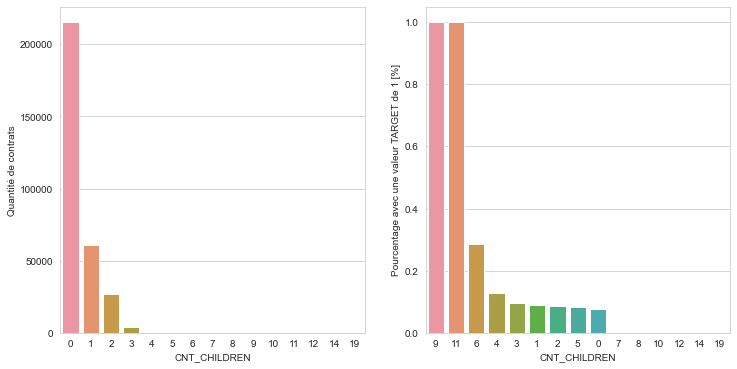

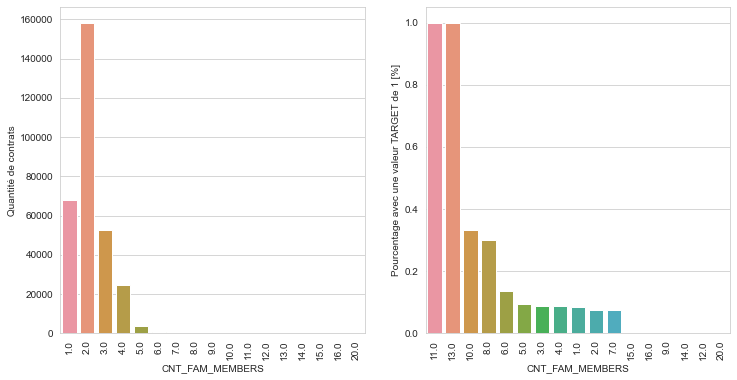

In [747]:
plot_stats('CNT_CHILDREN')
plot_stats('CNT_FAM_MEMBERS',True)

#### Profession
On voit ici que les "Low-skill laborers" ont plus de difficultés de rembourser un crédit et les comptables sont la profession qui rembourse le plus souvent sans problèmes.  
On voit également que les femmes en arrêt maternité et les chômeurs ont des difficultés à rembourser les crédits.  
Dans le dernier graphique, on peut constater que plus important le montant du crédit, plus souvent il est remboursé à temps. Il peut s'agir ici du phénomène que plus grand le révénu d'une personne, plus grand également le montant qu'il ou elle empruntent, et donc plus facilement il sera remboursé dû aux révénus de la personne.

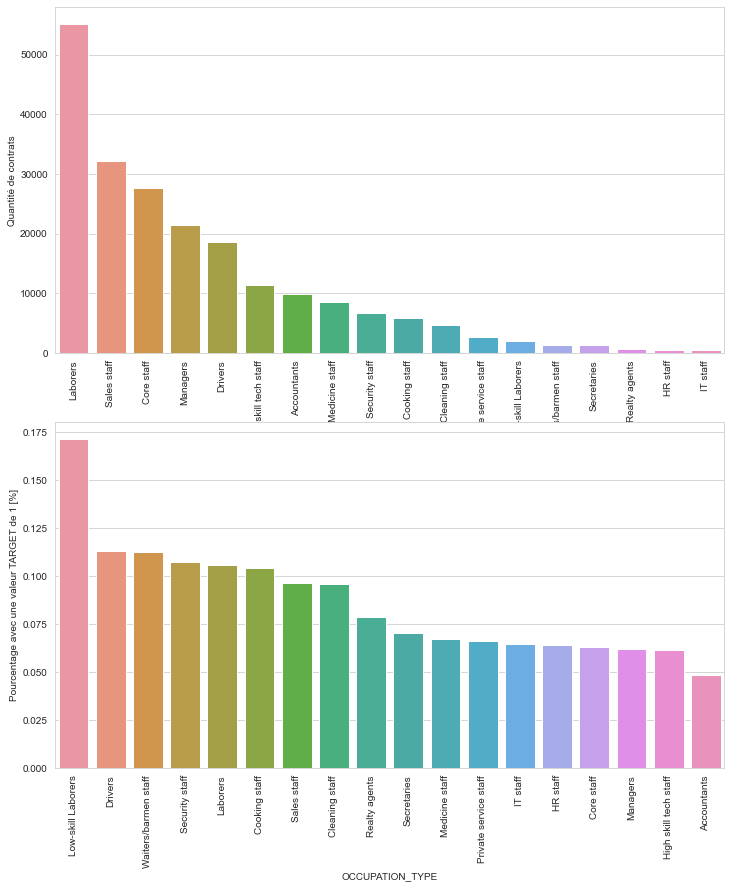

In [748]:
plot_stats('OCCUPATION_TYPE',True, False)

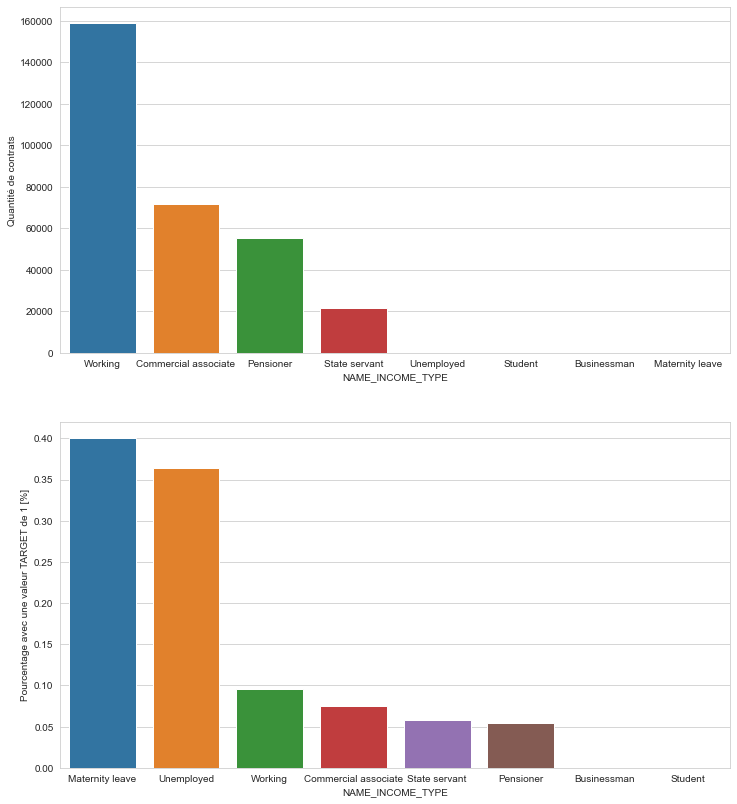

In [749]:
plot_stats('NAME_INCOME_TYPE',False,False)

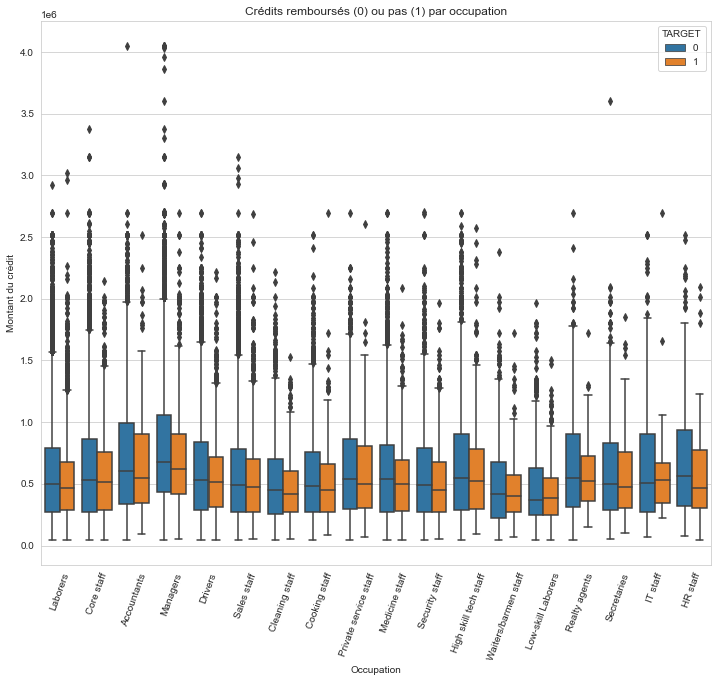

In [750]:
fig,ax = plt.subplots(figsize=(12,10))
sns.boxplot(x="OCCUPATION_TYPE", y="AMT_CREDIT", hue="TARGET", data=train)
plt.xlabel("Occupation")
plt.ylabel("Montant du crédit")
plt.title("Crédits remboursés (0) ou pas (1) par occupation")
plt.xticks(rotation=70)
plt.show()

#### Dernier diplôme obtenu
Ici nous pouvons constater une rélation entre le niveau d'études de la personne et de la possibilité de rembourser le prêt.

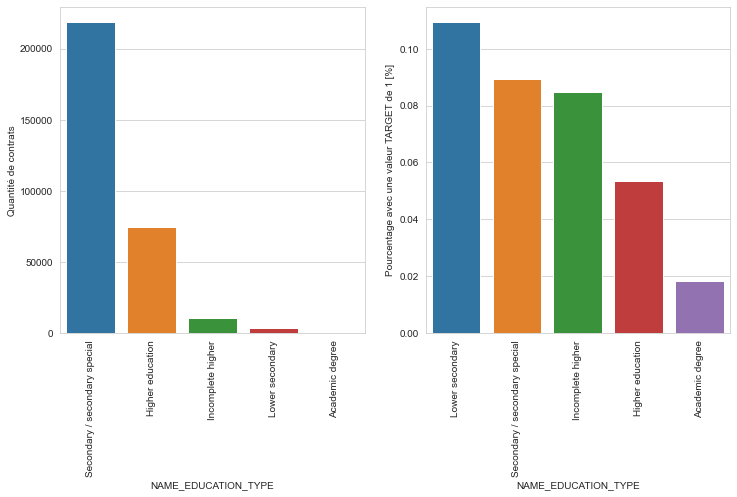

In [751]:
plot_stats('NAME_EDUCATION_TYPE',True)

#### Type d'habitation
Même si très peu des clients habitent avec leur parents, cette partie des clients ont beaucoup de difficultés à rembourser (comme les clients en habitation sociale, colocation, et "office apartment").

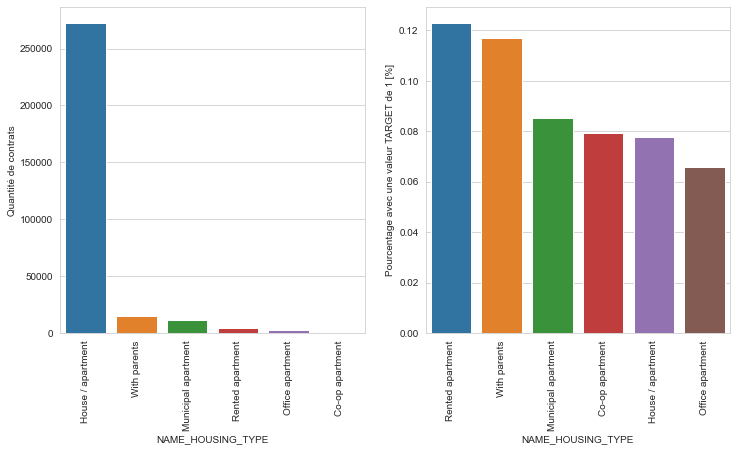

In [752]:
plot_stats('NAME_HOUSING_TYPE',True)

<b> Features numériques discrètes </b>

In [753]:
df_int.describe(include="all")

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


On constate une anomalie au niveau de DAYS_EMPLOYED, avec le max à 365243, ce qui corréspond à 1000 ans.  
Le plus probable est qu'il s'agit des clients au chômage, ou les clients pour lesquels il manque de l'information.  
Nous allons créer une feature flag et remplacer les anomalies par -1.

In [754]:
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Nous pouvons effectuer un petit nettoyage qui consiste en remplacer les anomalies par 0 et de remplacer les valeurs de DAYS_EMPLOYED, AMT_INCOME_TOTAL et DAYS_BIRTH, qui sont en négatif, par la valeur absolue.

In [755]:
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
train["DAYS_EMPLOYED"].replace(365243, 0, inplace = True)

test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace(365243, 0, inplace = True)

train["DAYS_EMPLOYED"] = abs(train["DAYS_EMPLOYED"])
test["DAYS_EMPLOYED"] = abs(test["DAYS_EMPLOYED"])

train["AMT_INCOME_TOTAL"] = abs(train["AMT_INCOME_TOTAL"])
test["AMT_INCOME_TOTAL"] = abs(test["AMT_INCOME_TOTAL"])

train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
test['DAYS_BIRTH'] = abs(test['DAYS_BIRTH'])

In [756]:
average_days_employed = round((train["DAYS_EMPLOYED"].mean())/365,2)
average_age = round((train["DAYS_BIRTH"].mean())/365,2)

print("La quantité d'années travaillés pour un client est en moyenne {} années et l'âge moyen d'un client est de {} ans".format(average_days_employed, average_age))

La quantité d'années travaillés pour un client est en moyenne 5.36 années et l'âge moyen d'un client est de 43.94 ans


#### Âge du client
Plus le client est âgé, moins il risque d'avoir des difficultés à rembourser.

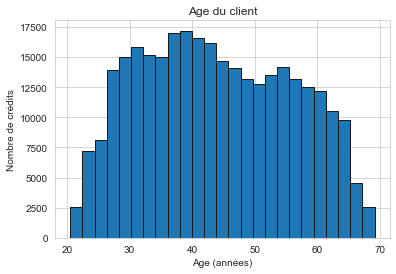

In [757]:
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du client'); plt.xlabel('Age (années)'); plt.ylabel('Nombre de crédits');

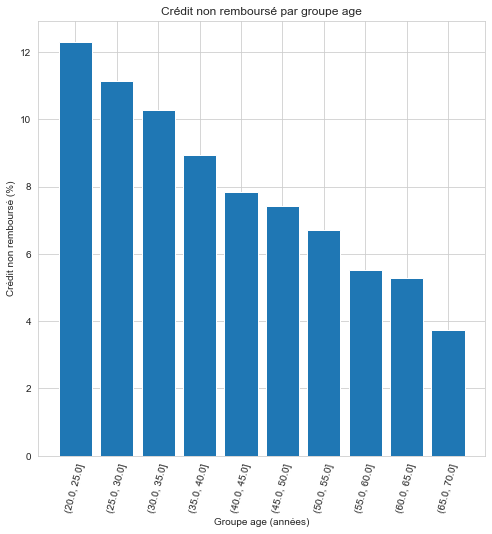

In [758]:
# Age information into a separate dataframe
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Groupe age (années)'); plt.ylabel('Crédit non remboursé (%)')
plt.title('Crédit non remboursé par groupe age');

#### Region du client

REG_REGION_NOT_LIVE_REGION : le client vit dans une autre region que leur adresse permanent
REG_REGION_NOT_WORK_REGION : le client vit dans une autre region que leur lieu de travail

Les clients qui ne vivent pas dans la même region que leur adresse permanent ou qui travaillent dans une autre region ont plus de difficultés à rembourser le crédit.

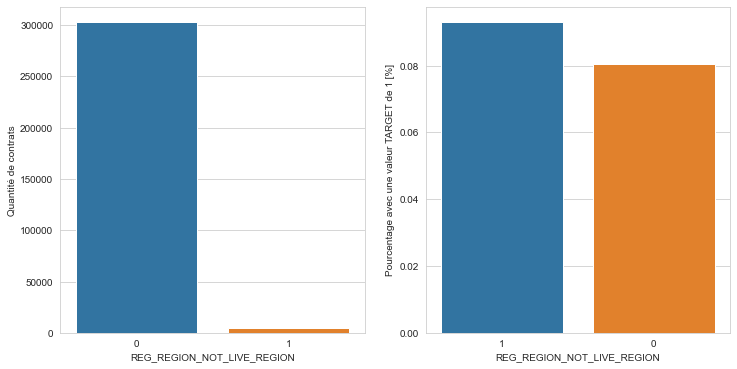

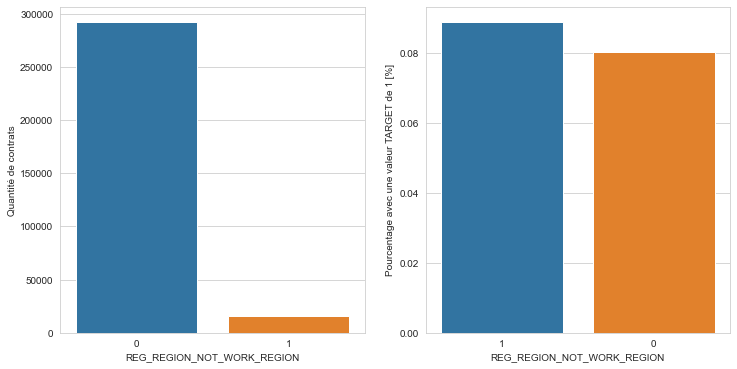

In [759]:
plot_stats('REG_REGION_NOT_LIVE_REGION')
plot_stats('REG_REGION_NOT_WORK_REGION')

#### Ville du client

REG_CITY_NOT_LIVE_CITY : le client vit dans une autre ville que leur adresse permanent
REG_CITY_NOT_WORK_CITY : le client vit dans une autre ville que leur lieu de travail

Les clients qui ont une ville d'adresse permanent différente de la ville d'adresse de contact ainsi qui les clients qui travaillent dans une autre ville que leur lieu de vie ont plus de difficultés à rembourser leur crédit.

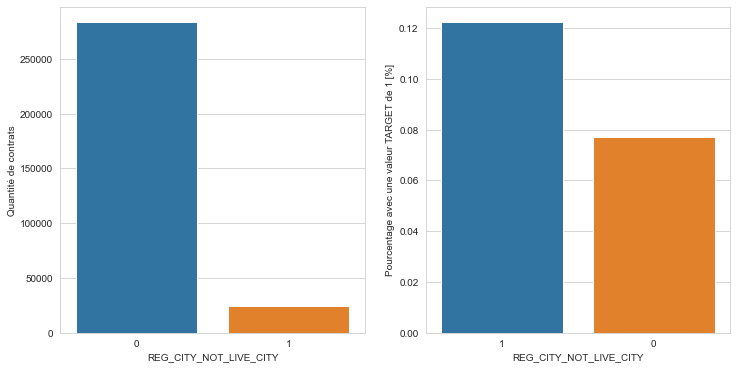

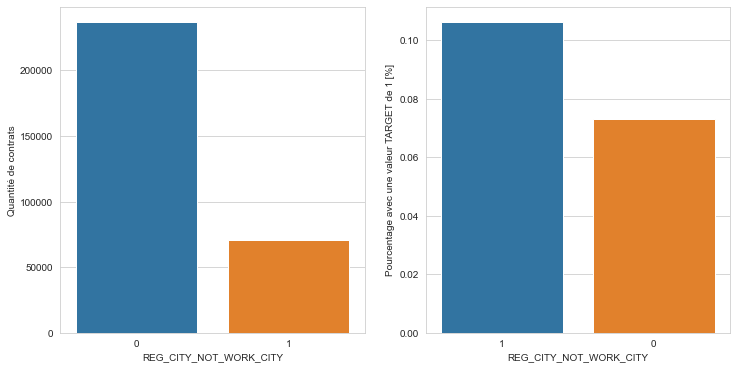

In [760]:
plot_stats('REG_CITY_NOT_LIVE_CITY')
plot_stats('REG_CITY_NOT_WORK_CITY')

<b> Features numériques continues </b>

In [761]:
df_float.describe(include="all")

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,5.000000,2.000000,0.334007,3.924574e-01,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,9.000000,2.000000,0.505998,5.659614e-01,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,15.000000,3.000000,0.675053,6.636171e-01,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,91.000000,20.000000,0.962693,8.549997e-01,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [762]:
income_monthly = round((df_float["AMT_INCOME_TOTAL"].mean()),2)
average_credit_amount = round(df_float["AMT_CREDIT"].mean(),2)

print("Le revenu moyen annuel est de {} et le montant moyen du crédit demandé est de {}".format(income_monthly, average_credit_amount))

Le revenu moyen annuel est de 168797.92 et le montant moyen du crédit demandé est de 599026.0


#### Revenu annuel

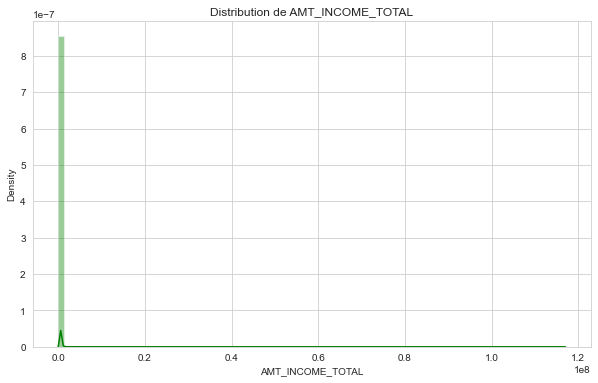

In [763]:
plot_distribution('AMT_INCOME_TOTAL','green')

#### Montant du crédit

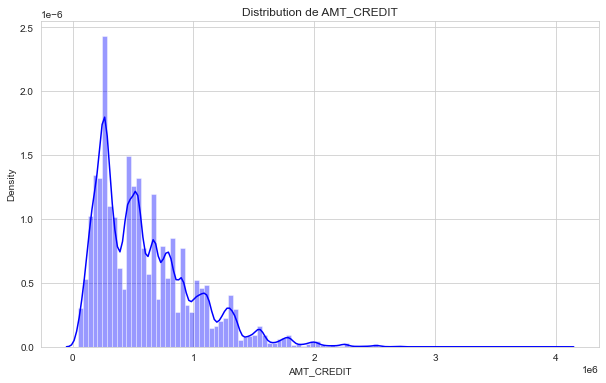

In [764]:
plot_distribution('AMT_CREDIT','blue')

#### Montant des annuités

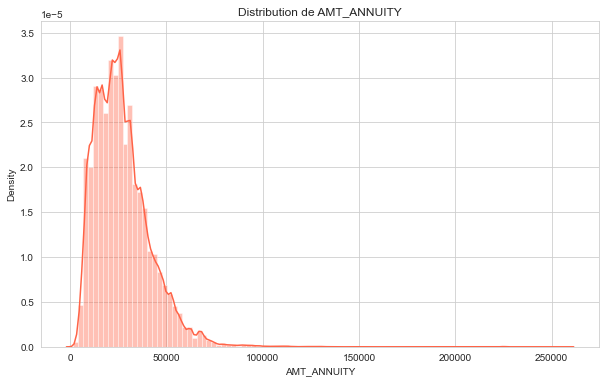

In [765]:
plot_distribution('AMT_ANNUITY','tomato')

#### Prix du bien acheté

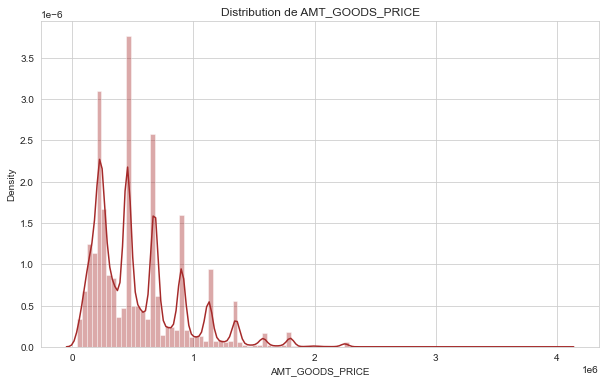

In [766]:
plot_distribution('AMT_GOODS_PRICE','brown')

#### Jours travaillés

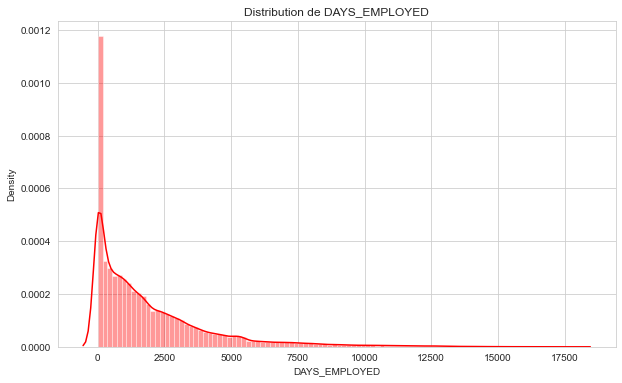

In [767]:
plot_distribution('DAYS_EMPLOYED','red')

#### Distributions : prêt remboursé en orange

Les formes sont très similaires pour les distributions, mais on voit par exemple de nouveau que les personnes plus âgés remboursent mieux un crédit. On voit également que plus récent le changement de la pièce d'identité, plus de difficultés à rembourser.

<Figure size 432x288 with 0 Axes>

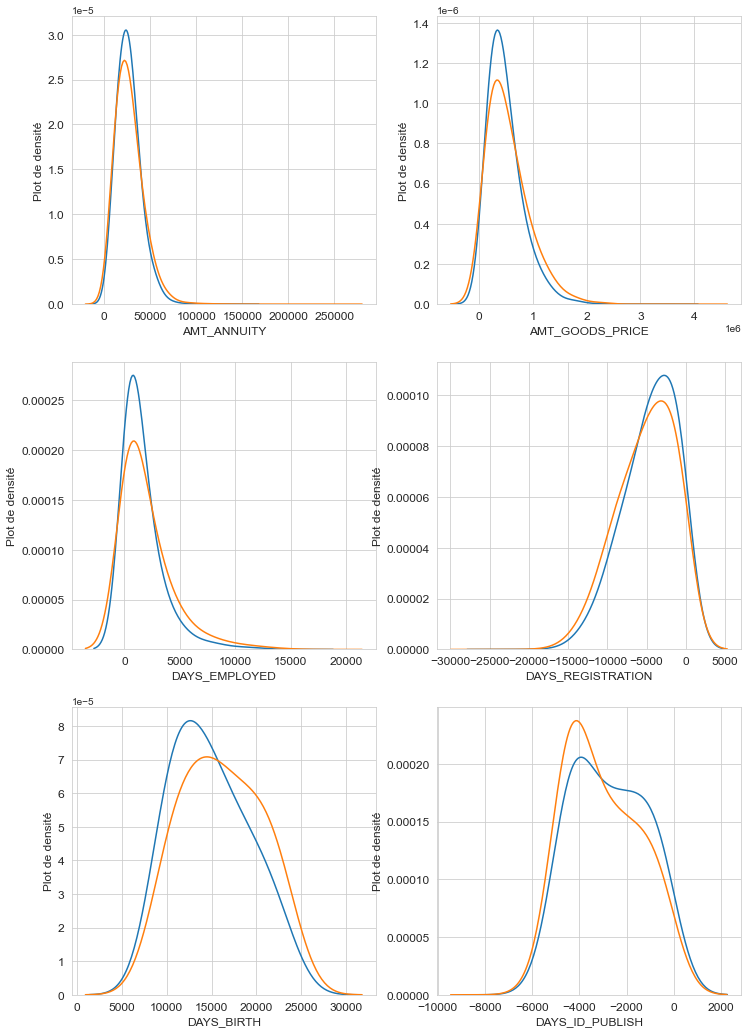

In [768]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=3)

## Valeurs manquantes

Nous allons commencer par supprimer les variables pour lesquels il nous manque plus que 60% des valeurs.

In [769]:
train = drop_cols_nans(train)
test = drop_cols_nans(test)

<AxesSubplot:>

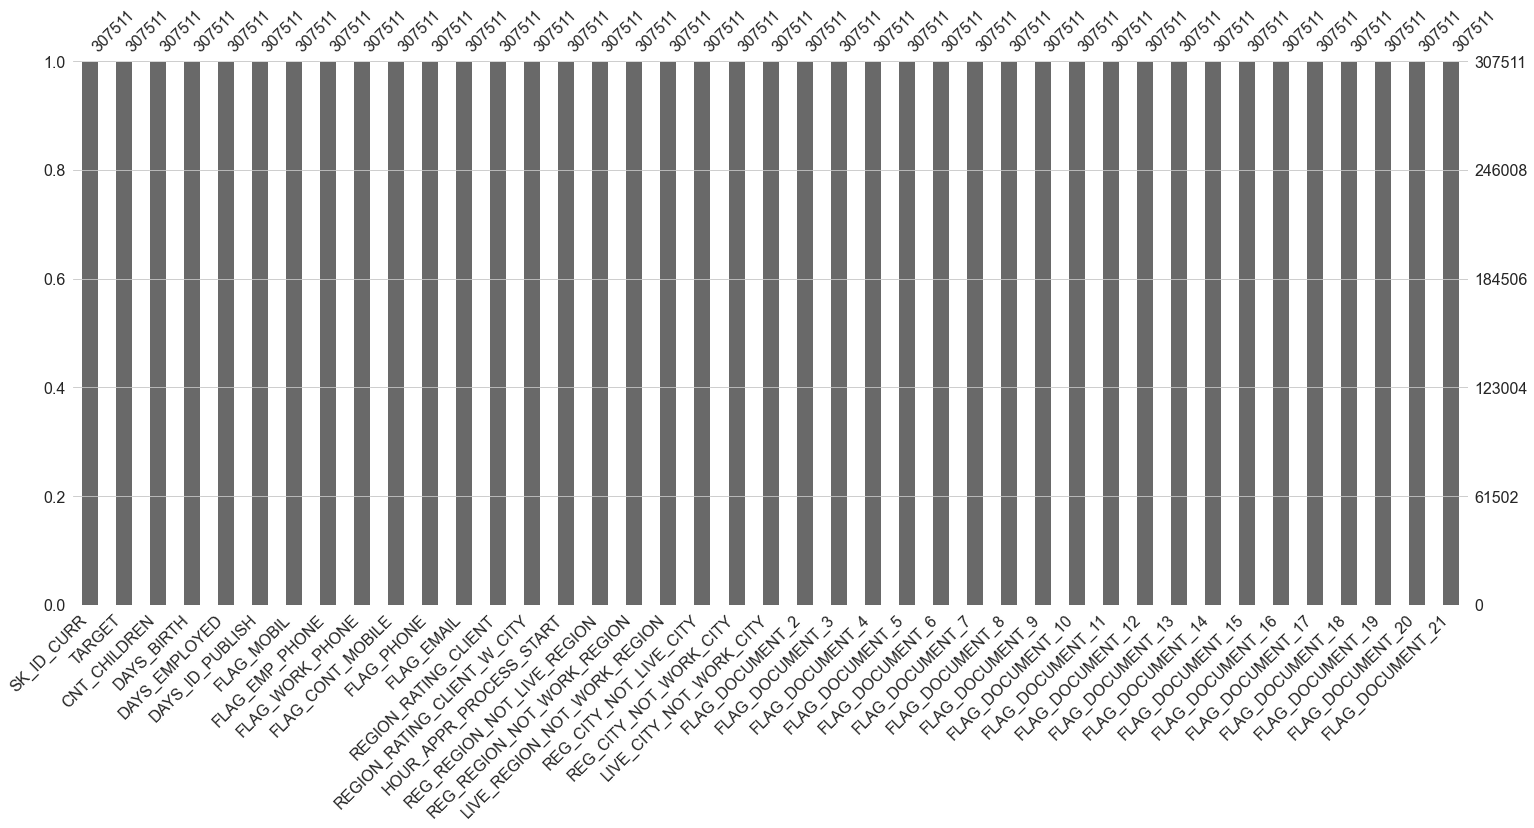

In [770]:
msno.bar(train.select_dtypes(['int64']))

Il n'y a plus de valeurs manquantes dans les features numériques discrètes.

<AxesSubplot:>

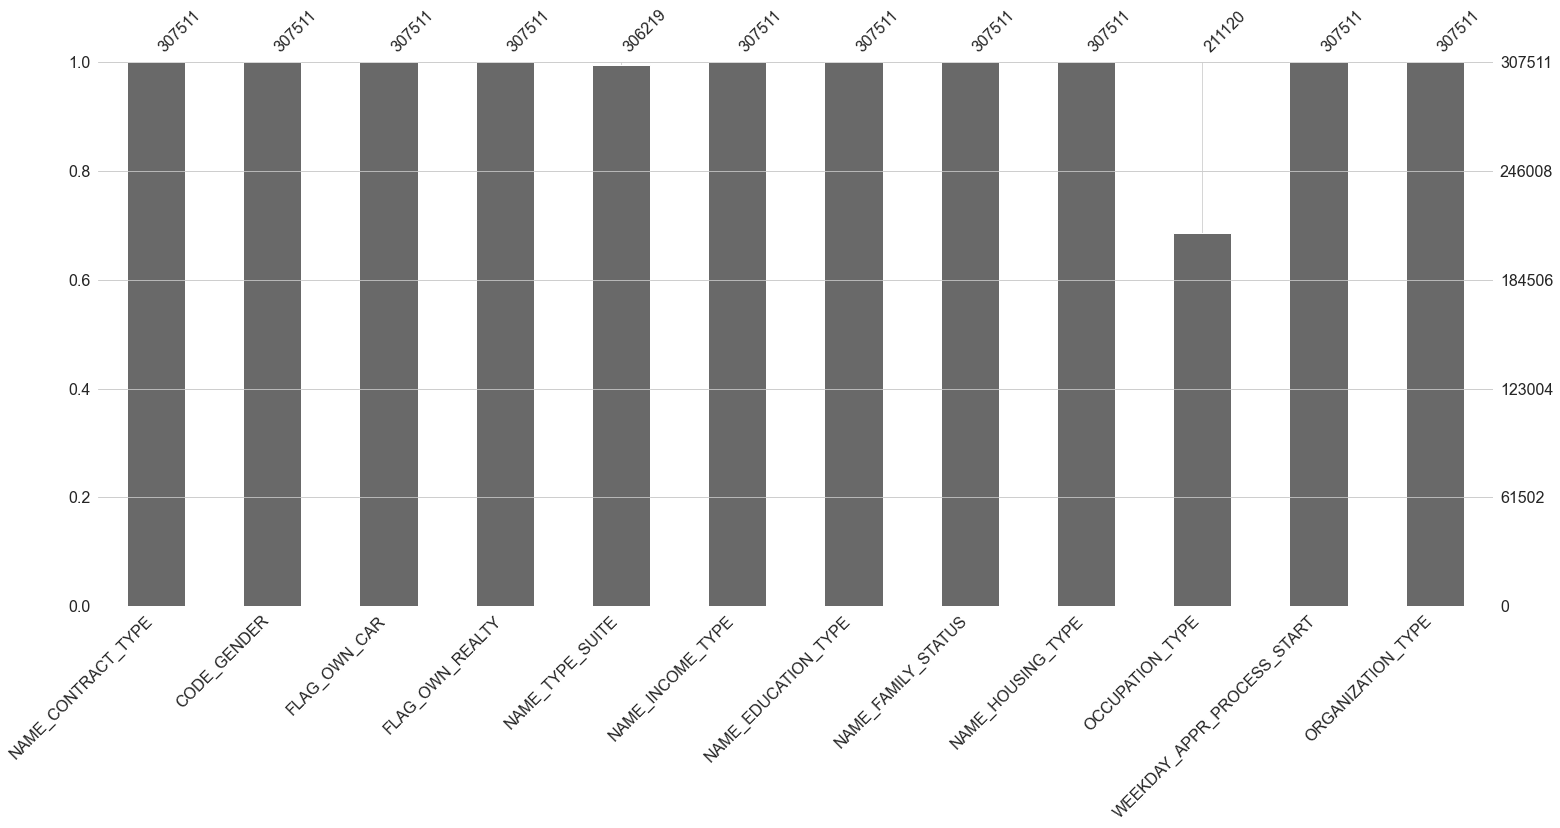

In [771]:
msno.bar(train.select_dtypes(['object']))

Il nous manque quelques renseignements pour la profession des clients, nous allons simplement remplacer par "Unknown".

In [772]:
train.select_dtypes(['object']).fillna("Unknown", inplace=True)
test.select_dtypes(['object']).fillna("Unknown", inplace=True)

<AxesSubplot:>

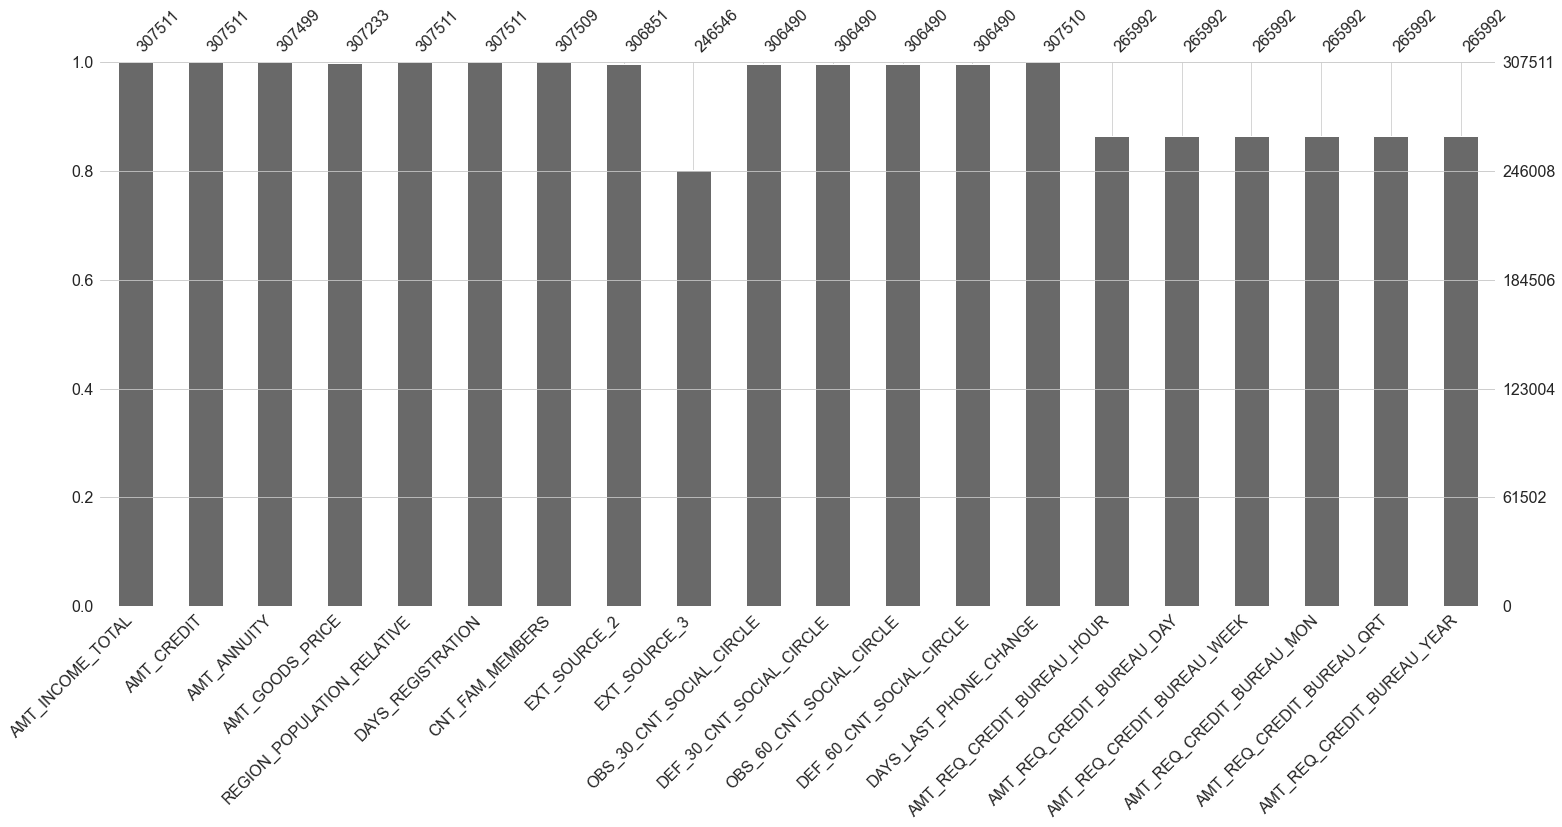

In [773]:
msno.bar(train.select_dtypes(['float64']))

Nous allons remplacer par la médiane de chaque colonne.

In [774]:
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

## Encodage des features categorielles

Afin de pouvoir utiliser notre jeu de données pour entraîner nos modèles, il faut que chaque feature soit numérique. Pour les features avec 2 ou moins valeurs uniques, nous allons utiliser LabelEncoder afin d'encoder les valeurs avec une chiffre 0 ou 1.  

Pour les autres features, qui ont plus de valeurs uniques que 2, il faudra utiliser OneHotEncoder, qui va créer une nouvelle colonne pour chaque catégorie dans notre feature et signaler dans la nouvelle colonne la catégorie à laquelle l'individu appartient.

In [775]:
# Créer un objet LabelEncoder
le = LabelEncoder()
le_count = 0

# Itérer dans les colonnes et encoder si maximum 2 variables uniques
for col in train:
    if train[col].dtype == 'object':

        if len(list(train[col].unique())) <= 2:
            # Entraîner sur le jeu d'entraînement
            le.fit(train[col])
            # Transformer le jeu d'entraînement et le jeu de test
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Compter les features encodés
            le_count += 1
            
print('%d features ont été encodés avec LabelEncoder.' % le_count)

3 features ont été encodés avec LabelEncoder.


In [776]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

Nous avons crée 63 colonnes supplémentaires.

## Aligner train et test

In [777]:
train_labels = train['TARGET']

# Aligner le jeu d'entraînement et le jeu de test, garder que les colonnes présentes dans les deux jeux de données
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('Training : ', train.shape)
print('Testing : ', test.shape)

Training :  (307511, 182)
Testing :  (48744, 181)


## Feature engineering

<b> Features domain knowledge </b>

Nous allons créer quelques features qui nous semblent logiques ou cohérentes et qui peuvent aider le modèle à bien prédire si le client peut rembourser le prêt ou pas.  

Il s'agit de nouvelles features qui sont des proportions entre nos features les plus intéressantes au niveau de la détection des clients qui ne remboursent bien les crédits. Par exemple : la quantité d'enfants dans la famille, l'âge, le montant du crédit, le prix du bien achêté, ou le revenu.  

Nous avons vu aussi, par exemple, que les features extérieures (EXT_SOURCE_#) ont une rélation importante avec notre TARGET. Nous pouvons utiliser ces informations afin de créer nos nouvelles features polynômes qui vont augmenter l'importance de la feature et aider notre modèle à détecter les clients qui auront des difficultés.

In [778]:
# New feature: income per person

train["income_per_pers"] = train["AMT_INCOME_TOTAL"] / (train["CNT_CHILDREN"]+1)
test["income_per_pers"] = test["AMT_INCOME_TOTAL"] / (test["CNT_CHILDREN"]+1)

# New feature: ratio of time employed vs birth

train["employed_birth_ratio"] = train["DAYS_EMPLOYED"] / train["DAYS_BIRTH"]
test["employed_birth_ratio"] = test["DAYS_EMPLOYED"] / test["DAYS_BIRTH"]

# New feature: credit amount vs goods price

train["credit_price_ratio"] = train["AMT_GOODS_PRICE"] / train["AMT_CREDIT"]
test["credit_price_ratio"] = test["AMT_GOODS_PRICE"] / test["AMT_CREDIT"]

# New feature: ratio of annuity to total credit amount

train["annuity_credit_ratio"] = train["AMT_ANNUITY"] / train["AMT_CREDIT"]
test["annuity_credit_ratio"] = test["AMT_ANNUITY"] / test["AMT_CREDIT"]

# New feature: ratio of annuity to revenue

train["annuity_revenue_ratio"] = train["AMT_ANNUITY"] / train["AMT_INCOME_TOTAL"]
test["annuity_revenue_ratio"] = test["AMT_ANNUITY"] / test["AMT_INCOME_TOTAL"]

# New feature: ratio of credit to revenue

train['credit_income_ratio'] = train['AMT_CREDIT'] / train["AMT_INCOME_TOTAL"]
test['credit_income_ratio'] = test['AMT_CREDIT'] / test["AMT_INCOME_TOTAL"]

# Nouvelle feature : documents transmis

train["docs_submitted"] = (train["FLAG_DOCUMENT_2"] + train["FLAG_DOCUMENT_3"] + train["FLAG_DOCUMENT_5"] + train["FLAG_DOCUMENT_6"] + train["FLAG_DOCUMENT_7"] +
                            train["FLAG_DOCUMENT_8"] + train["FLAG_DOCUMENT_9"] + train["FLAG_DOCUMENT_10"] + train["FLAG_DOCUMENT_11"] + train["FLAG_DOCUMENT_12"] + train["FLAG_DOCUMENT_13"] +
                            train["FLAG_DOCUMENT_14"] + train["FLAG_DOCUMENT_15"] + train["FLAG_DOCUMENT_16"] + train["FLAG_DOCUMENT_17"] + train["FLAG_DOCUMENT_18"] + train["FLAG_DOCUMENT_19"] +
                            train["FLAG_DOCUMENT_20"] + train["FLAG_DOCUMENT_21"])

test["docs_submitted"] = (test["FLAG_DOCUMENT_2"] + test["FLAG_DOCUMENT_3"] + test["FLAG_DOCUMENT_5"] + test["FLAG_DOCUMENT_6"] + test["FLAG_DOCUMENT_7"] +
                            test["FLAG_DOCUMENT_8"] + test["FLAG_DOCUMENT_9"] + test["FLAG_DOCUMENT_10"] + test["FLAG_DOCUMENT_11"] + test["FLAG_DOCUMENT_12"] + test["FLAG_DOCUMENT_13"] +
                            test["FLAG_DOCUMENT_14"] + test["FLAG_DOCUMENT_15"] + test["FLAG_DOCUMENT_16"] + test["FLAG_DOCUMENT_17"] + test["FLAG_DOCUMENT_18"] + test["FLAG_DOCUMENT_19"] +
                            test["FLAG_DOCUMENT_20"] + test["FLAG_DOCUMENT_21"])

# Nouvelle feature : flags des features correlés avec le non-remboursement

train['neg_feats'] = (train['NAME_EDUCATION_TYPE_Lower secondary'] + train['NAME_INCOME_TYPE_Unemployed'] + train['OCCUPATION_TYPE_Low-skill Laborers'] + train['NAME_HOUSING_TYPE_With parents'] +
                        train['REG_CITY_NOT_LIVE_CITY'] + train['REG_REGION_NOT_WORK_REGION'] + train['REG_CITY_NOT_LIVE_CITY'] + train['REG_CITY_NOT_WORK_CITY'])

test['neg_feats'] = (test['NAME_EDUCATION_TYPE_Lower secondary'] + test['NAME_INCOME_TYPE_Unemployed'] + test['OCCUPATION_TYPE_Low-skill Laborers'] + test['NAME_HOUSING_TYPE_With parents'] +
                        test['REG_CITY_NOT_LIVE_CITY'] + test['REG_REGION_NOT_WORK_REGION'] + test['REG_CITY_NOT_LIVE_CITY'] + test['REG_CITY_NOT_WORK_CITY'])

<b> Features polynômes </b>

D'après le heatmap ci-bas, il existe une corrélation entre les variables de source extérieure (EXT_SOURCE_2, EXT_SOURCE_3), DAYS_BIRTH et TARGET, nous pouvons essayer de booster notre futur modèle avec quelques features polynômes.

Text(0.5, 1.0, 'Correlation HeatMap')

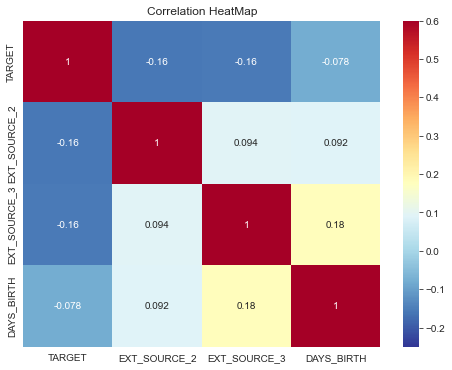

In [779]:
ext_data = train[['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25,
            annot=True, vmax=0.6)
plt.title('Correlation HeatMap')

In [780]:
# New polynomial features: 

train["ext_sources"] = pow(train["EXT_SOURCE_2"], 2) + pow(train["EXT_SOURCE_3"], 2)
train["ext_sources_2"] = pow(-train["EXT_SOURCE_2"], 2)*pow(train["DAYS_BIRTH"], 2) + pow(train["EXT_SOURCE_3"], 2) 

test["ext_sources"] = pow(test["EXT_SOURCE_2"], 2) + pow(test["EXT_SOURCE_3"], 2)
test["ext_sources_2"] = pow(test["EXT_SOURCE_2"], 2)*pow(test["DAYS_BIRTH"], 2) + pow(test["EXT_SOURCE_3"], 2)

In [781]:
# Pour se rassurer de ne pas avoir de problèmes de division par 0

train.replace([np.inf, -np.inf], 0, inplace=True)
test.replace([np.inf, -np.inf], 0, inplace=True)

## Feature importance

Le processus de choix des meilleures features a été un processus itératif. La première étape consistait en étudier les corrélations entre les features et le TARGET.   

À l'aide de l'algorithme SelectKBest, qui choisit les "k" meilleures features correlées à TARGET, j'ai pu faire un premier choix de 75 features, qui est beaucoup trop. Si nous avons beaucoup de features, cela va créer du bruit pour notre modèle et il aura des difficultés à bien prédire. Si nous avons qu'une vingtaine de features qui sont importantes pour le modèle, il pourra prédire plus facilement.  

J'ai ensuite pu choisir le modèle le plus performant (detaillé dans le deuxième notebook dedié au modèle) et grâce à ce modèle j'ai pu choisir les features les plus importantes. Le résultat de ce processus de recherche itératif m'a mené à choisir les features qui suivent pour la suite de ce projet (auxquels s'ajoutent les features que nous avons crée et seront supprimés les features avec trop de collinéarité entre-eux) : 

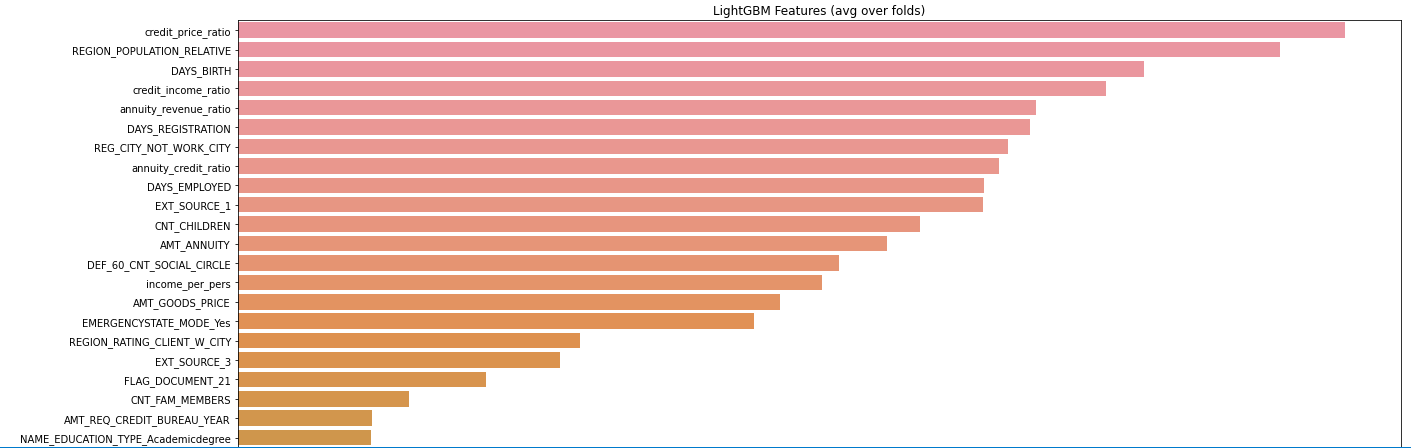

In [782]:
from IPython import display
display.Image("https://raw.githubusercontent.com/katrinmisel/HomeCreditDefaultRisk/main/if_lgb.PNG")

In [783]:
important_features = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS', 'CODE_GENDER_F', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
                    'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NAME_EDUCATION_TYPE_Academicdegree',
                    'NAME_EDUCATION_TYPE_Highereducation', 'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'annuity_credit_ratio', 'annuity_revenue_ratio',
                    'credit_income_ratio', 'credit_price_ratio','employed_birth_ratio', 'ext_sources', 'ext_sources_2', 'income_per_pers', 'neg_feats', "docs_submitted"]

# Nous gardons que les features importantes
train = train.drop(columns=[col for col in train if col not in important_features])
test = test.drop(columns=[col for col in test if col not in important_features])

#### Gestion de la collinéarité

Cela ne sert à rien de garder des features qui sont trop correlés entre-eux. Nous allons donc chercher les features qui ont plus de 80% de colinéarité et garder qu'une d'elles (celle qui a le plus de correlation avec TARGET).

<AxesSubplot:>

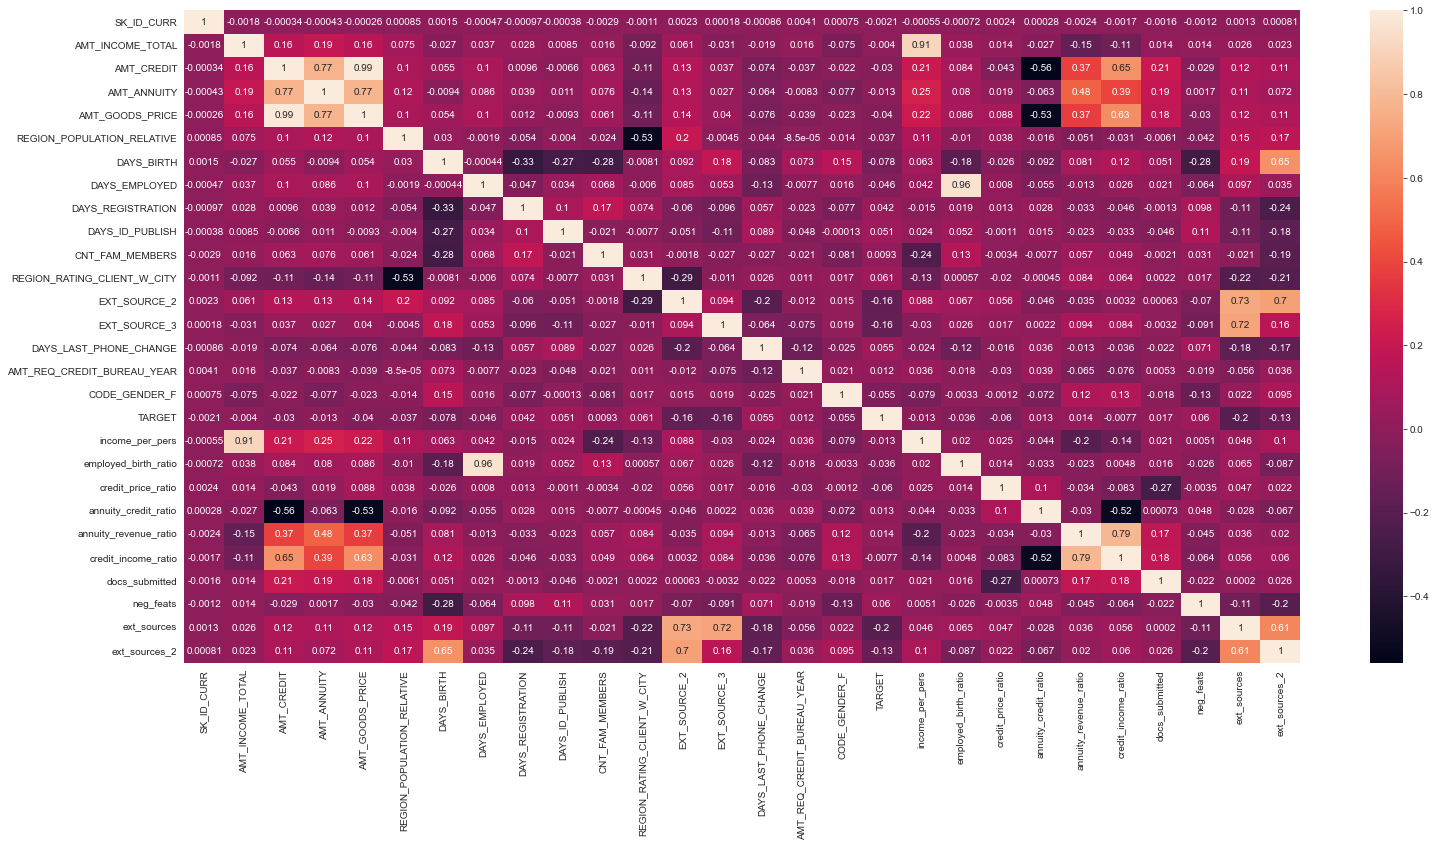

In [784]:
f, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(train.corr(), annot=True)

In [785]:
# Fonction qui crée une liste de features à supprimer

def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                feat_i = correlations.columns[i]
                feat_j = correlations.columns[j]
                if (abs(train[feat_i].corr(train['TARGET'])) > abs(train[feat_j].corr(train['TARGET']))):
                    correlated_columns.add(correlations.columns[j])
                elif (abs(train[feat_j].corr(train['TARGET'])) > abs(train[feat_i].corr(train['TARGET']))):
                    correlated_columns.add(correlations.columns[i])
    return correlated_columns

In [786]:
coll_feats_to_drop = correlatedFeatures(train, 0.80)

train = train.drop(columns=coll_feats_to_drop)
test = test.drop(columns=coll_feats_to_drop)

print("Il nous reste " + str(train.shape[1]) + " features.")

Il nous reste 25 features.


In [787]:
train.columns

Index(['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_F',
       'TARGET', 'income_per_pers', 'credit_price_ratio',
       'annuity_credit_ratio', 'annuity_revenue_ratio', 'credit_income_ratio',
       'docs_submitted', 'neg_feats', 'ext_sources', 'ext_sources_2'],
      dtype='object')

In [788]:
train = abs(train)
test = abs(test)

In [789]:
# Sauvegarde des résultats pour le prochain notebook

train.to_csv("train_clean.csv")
test.to_csv("test_clean.csv")